In [18]:
# Load libraries

import numpy as np
import scipy
from scipy.ndimage import convolve1d
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
import os
import sys

import librosa
import librosa.display

In [19]:
# Load data

directory_path = '/home/daansan/David/MusicDetection/data/'
# filename = 'fragment.wav'
filename = 'voice.wav'
# filename = 'call_test.wav'
# filename = 'ladygaga2.wav'

# Load the audio
sr, data = read(os.path.join(directory_path, filename))

In [20]:
# Insulate one track and normalize

x = data[:, 1].astype(np.float32)
x = x / np.abs(x).max() / 2

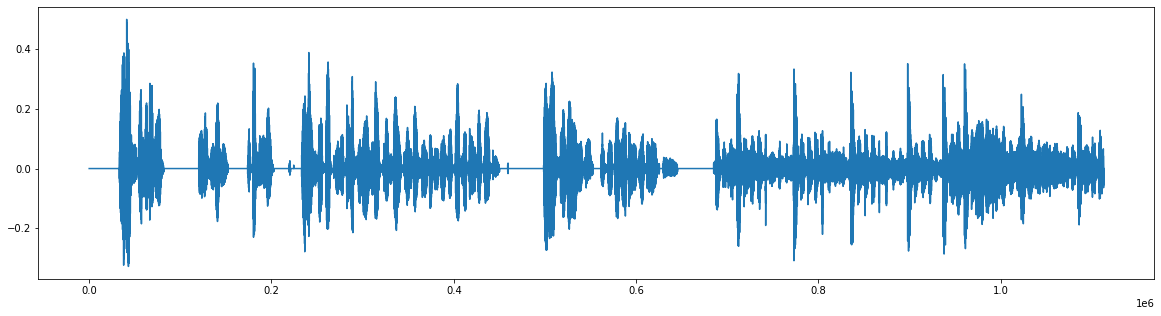

In [21]:
# Plot soundwave

plt.figure(figsize=(20, 5))
plt.plot(x * (np.abs(x) > 0.01))
plt.show()

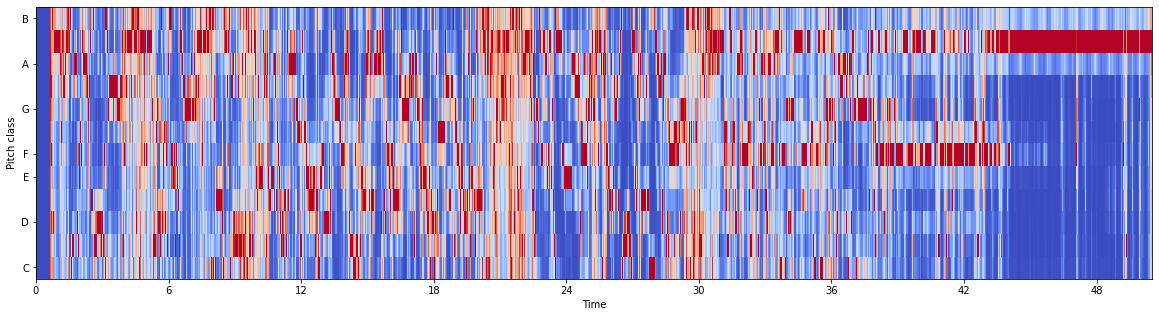

In [22]:
#  Get chromagram and plot it

hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(20, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.show()

In [23]:
def silences(data, hop_length=512):
    """Detects where silences are and it returns a numpy array with 
    their time location in the audio signal

    Parameters
    ----------
    data : numpy array
        The audio signal imported with scipy.io.wavfile
    hop_length : integer
        Hop length for the STFT (default is 512)

    Returns
    -------
    numpy array
        A numpy array with values False if silence and True if sound
        of the same size as the original signal array
    """
    silences = [0]
    
    for i in range(0, data.shape[0], hop_length):
        x = data[i:i+hop_length].max()
        silences.append(x * np.abs(x) > 0.0001)
        
    return np.array(silences)

silences_location = silences(x, hop_length)
silences_location = silences_location[:, np.newaxis]

# Clean fragments with silences
chroma_no_silence = chromagram * silences_location[:chromagram.shape[1]].T

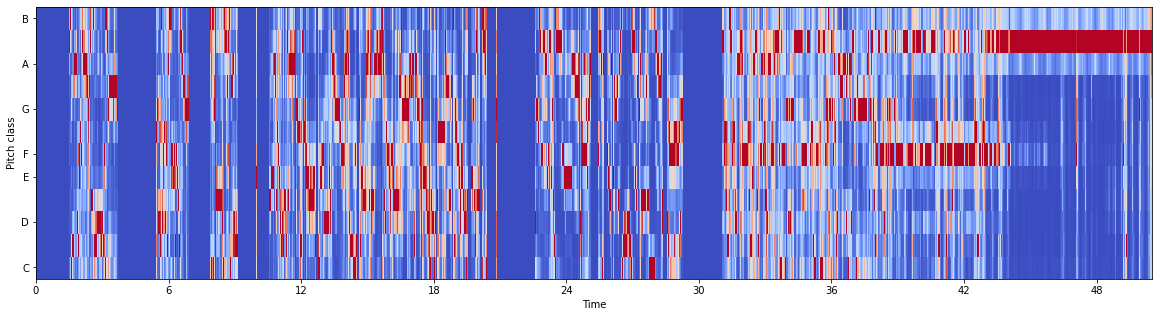

In [24]:
# Plot chromagram without tones corresponding to silences

plt.figure(figsize=(20, 5))
librosa.display.specshow(chroma_no_silence, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.show()

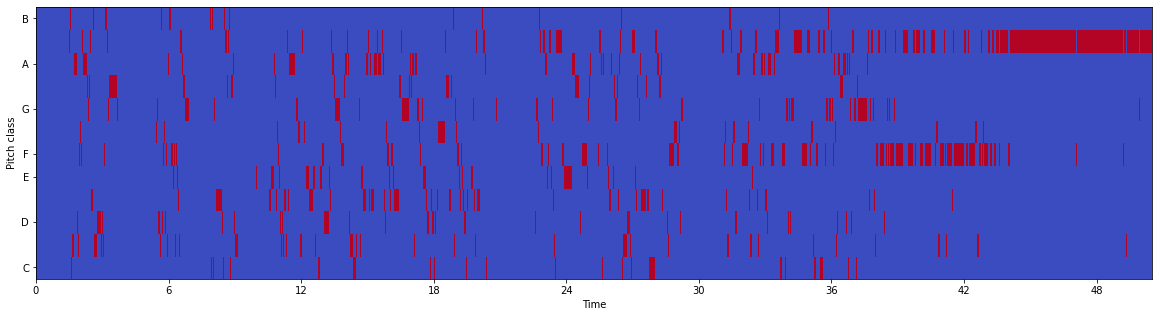

In [49]:
# Plot chromagram with maximum amplitudes only

plt.figure(figsize=(20, 5))
librosa.display.specshow(np.ceil(chroma_no_silence * (chroma_no_silence >= 1)), x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.show()

In [50]:
# Filter chroma values by window

window = 30 # ~0.4s
filter_value = 10

# keep only maximum amplitudes
chroma_filter = np.ceil(chroma_no_silence * (chroma_no_silence>=1))

# get duration of the audio track
length = x.size / sr 

# define time array 
time = np.arange(chroma_no_silence.shape[1]) / chroma_no_silence.shape[1]*length

for i in range(0, chroma_filter.shape[1], window):
    
    # create windows-sized sections of the chroma
    section = chroma_filter[:, i:i+window]
    
    # sum chroma values for the current section
    sum_section = section.sum(axis=1)
    
    # filter results by optimised value and apply to section
    filter = sum_section > filter_value
    filter = filter[:, np.newaxis]
    chroma_filter[:, i:i+window] = section * filter    


/home/daansan/David/MusicDetection/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


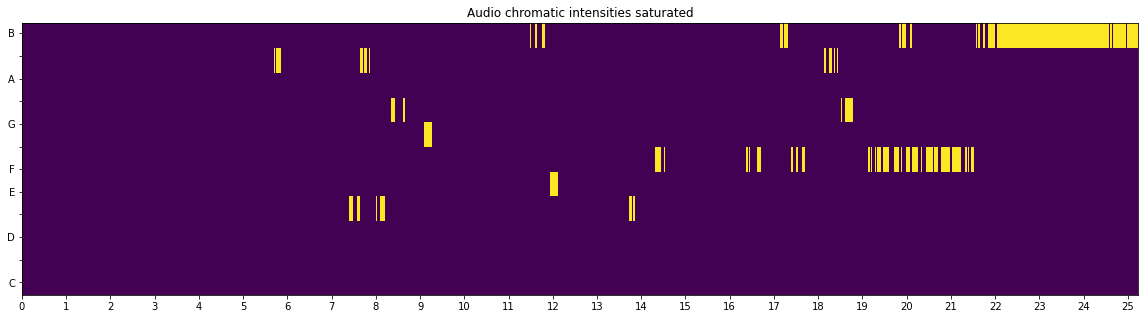

In [52]:
fig, ax = plt.subplots(figsize=(20, 5));
plt.pcolor(time, np.arange(12), chroma_filter);
plt.xticks(np.arange(0, length, 1));
plt.yticks(np.arange(0.5, 11.5, 11/12));
ax.set_yticklabels(['C','','D','','E','F','','G','','A','','B']);
plt.title('Audio chromatic intensities saturated');
plt.show()

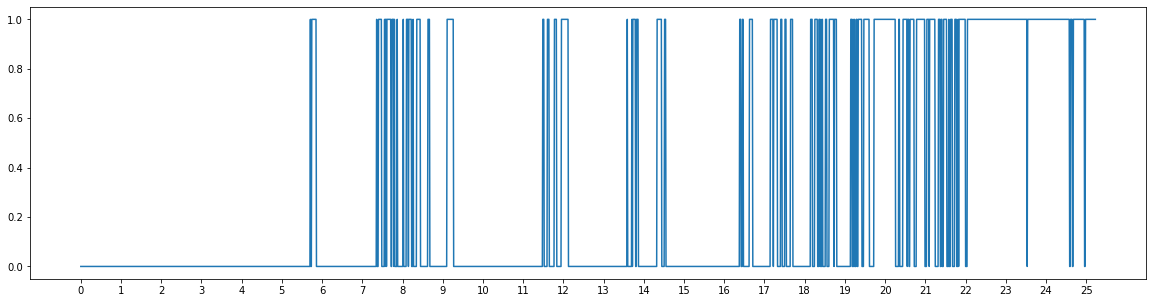

In [55]:
# Plot first outcome of the problem

fig, ax = plt.subplots(figsize=(20, 5));
plt.plot(time, chroma_filter.max(axis=0))
plt.xticks(np.arange(0, length, 1))
plt.show()

In [56]:
# Convolve to detect constant patterns

integration_time = 10
hammer_window = np.ones(integration_time)
convolved_chromagram = convolve1d(chroma_filter, hammer_window) / convolve1d(chroma_filter, hammer_window).mean() > 0.6 
convolved_chromagram = np.ceil(convolved_chromagram)

/home/daansan/David/MusicDetection/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


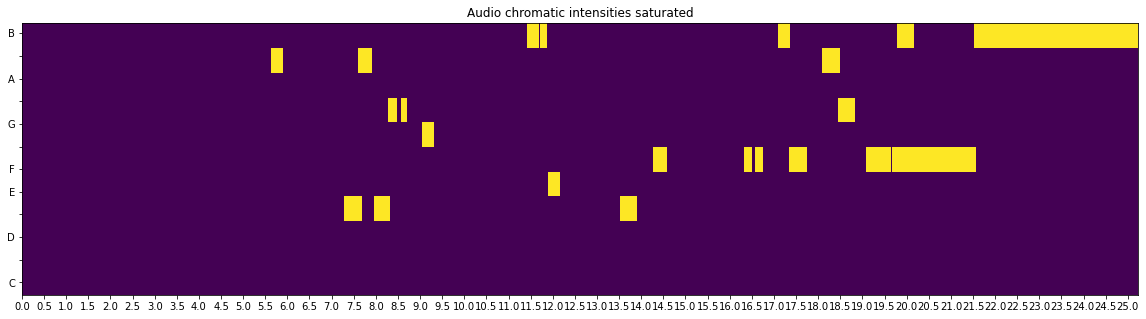

In [57]:
fig, ax = plt.subplots(figsize=(20, 5));
plt.pcolor(time,np.arange(12), convolved_chromagram);
plt.xticks(np.arange(0, length, 0.5));
plt.yticks(np.arange(0.5, 11.5, 11/12));
ax.set_yticklabels(['C','','D','','E','F','','G','','A','','B']);
plt.title('Audio chromatic intensities saturated');

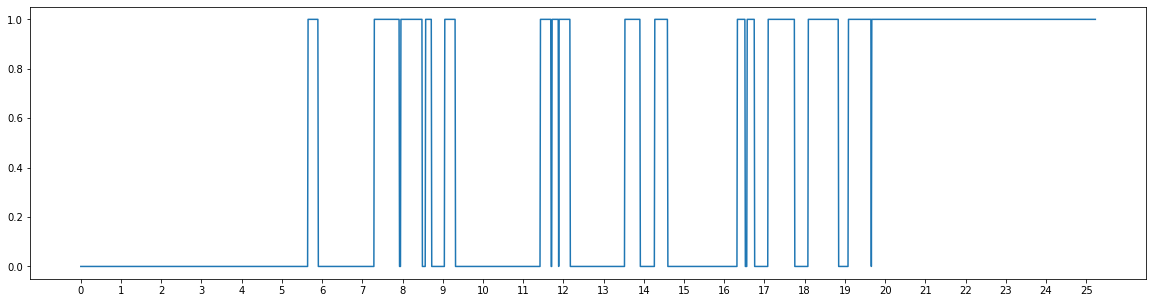

In [60]:
# Plot second outcome of the problem after convolution

fig, ax = plt.subplots(figsize=(20,5));
plt.plot(time,convolved_chromagram.max(axis=0))
plt.xticks(np.arange(0,length,1))
plt.show()

In [76]:
# Detect isolated music/voice incidences in the next 3 seconds

signal = convolved_chromagram.max(axis=0)
window = 260

signal_filtered = []
for i in range(signal.shape[0]):
    signal_filtered.append(signal[i:i+window].mean() > 0.55)

In [77]:
# Final outcome with a time delay to compensate previous windows filter
delay = 1.5
time = time+delay
time[0] = 0
time[time > length] = length
music = signal_filtered

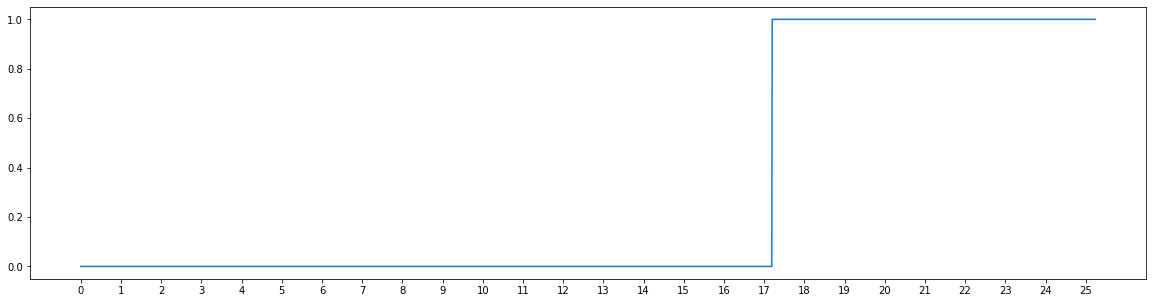

In [78]:
# Plot outcome
fig, ax = plt.subplots(figsize=(20,5));
plt.plot(time, music)
plt.xticks(np.arange(0,length,1))
plt.show()  